# Анализ данных в задаче кредитного скоринга

In [42]:
# Импорт библиотек
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
# Считываем исходные данные
df = pd.read_csv('credit_card_default_analysis.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Задание 1

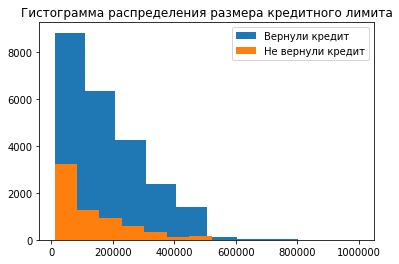

In [44]:
#Построим гистограммы распределения размера кредитного лимита
paid = df[df.default == 0].LIMIT_BAL.values
default = df[df.default == 1].LIMIT_BAL.values
plt.hist(paid, label="Вернули кредит")
plt.hist(default, label="Не вернули кредит")
plt.title("Гистограмма распределения размера кредитного лимита")
plt.legend()

Из гистограммы следует, размер кредитного лимита у тех, кто вернул кредит, значительно выше, чем у тех, кто не вернул

In [45]:
# Рассчитаем доверительный интервал для разности медиан с помощью бутстрепа и проверим гипотезу о равенстве медиан: 
# H0: M1=M2 (медианы равны)
# H1: M1!= M2 (медианы не равны)

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

np.random.seed(0)

paid_median_scores = list(map(np.median, get_bootstrap_samples(paid, 1000)))
default_median_scores = list(map(np.median, get_bootstrap_samples(default, 1000)))

print("Точечная оценка медины кредитного лимита для выплативших кредит: ", np.median(paid))
print("Точечная оценка медины кредитного лимита для невыплативших кредит: ", np.median(default))

delta_median_scores = list(map(lambda x: x[0] - x[1], zip(paid_median_scores, default_median_scores)))
print("95% доверительный интервал для разности медиан",  stat_intervals(delta_median_scores, 0.05))

Точечная оценка медины кредитного лимита для выплативших кредит:  150000.0
Точечная оценка медины кредитного лимита для невыплативших кредит:  90000.0
95% доверительный интервал для разности медиан [60000. 70000.]


95% Доверительный интервал для разности медиан кредитного лимита вернувших и не вернувших кредит не содержит 0, значит гипотеза о равенстве медиан отвергается. Границы интервала достаточно далеко удалены от 0, и имеют большие абсолютные значения, поэтому данный результат можно считать практически значимым.

In [46]:
# Проверим гипотезу о равенстве распределений кредитного лимита для вернувших и невернувших кредит с помощью критерия Манна-Уитни (так как выборки независимы)
# H0: F_x1(x) = F_x2(x) (выборки получены из одного распределения)
# H1: F_x1(x) = F_x2(x + delta), delta != 0 (выборки получены из разных распределений)

def hypothesis_check(p, alpha=0.05):
    print("Достигаемый уровень значимости:", p)
    if p < alpha:
        print("Гипотеза Н0 отвергается на уровне значимости", alpha)
    else:
        print("Гипотеза Н0 принимается на уровне значимости", alpha)

_, p = sts.mannwhitneyu(paid, default, alternative="two-sided")
hypothesis_check(p)

Достигаемый уровень значимости: 1.2255485818223303e-189
Гипотеза Н0 отвергается на уровне значимости 0.05


Гипотезу о равенстве распределения кредитного лимита вернувших и не вернувших кредит можно уверенно отвергнуть

## Задание 2

Text(0.5, 1.0, 'Гистограмма распределения пола\nдля невыплативших кредит')

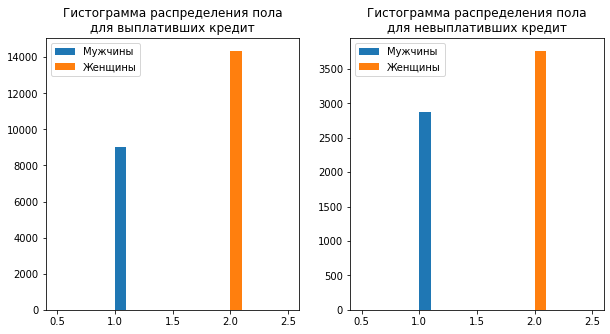

In [47]:
# Построим гистограммы распределения мужчин и женщин среди тех, кто вернул и не вернул кредит
paid = df[df.default == 0].SEX
default = df[df.default == 1].SEX
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].hist(paid[paid == 1] ,label="Мужчины")
axes[0].hist(paid[paid == 2] ,label="Женщины")
axes[0].legend()
axes[0].set_title("Гистограмма распределения пола\nдля выплативших кредит")
axes[1].hist(default[default == 1] ,label="Мужчины")
axes[1].hist(default[default == 2] ,label="Женщины")
axes[1].legend()
axes[1].set_title("Гистограмма распределения пола\nдля невыплативших кредит")

На гистограммах видно, что доля женщин среди выплативших кредит выше, чем среди невыплативших.

In [48]:
# Построим 95% доверительный интервал для разности долей мужчин и женщин среди выплативших и невыплативших кредит (выборки независимы)
# и проверим гипотезу о равенстве долей женщин среди выплативших и невыплативших кредит
# H0: p1 = p2 (доли женщин равны)
# H1: p1 != p2 (доли женщин не равны)

def proportions_confint_diff_ind(p1, n1, p2, n2, alpha = 0.05):    
    z = sts.norm.ppf(1 - alpha / 2.)   
    diff = z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)

    left_boundary = (p1 - p2) - diff
    right_boundary = (p1 - p2) + diff
    
    return (left_boundary, right_boundary)

p1 = len(paid[paid == 2])
n1 = len(paid)
p2 = len(default[default == 2])
n2 = len(default)

print("Точечная оценка доли женщин среди выплативших кредит:", round(p1 / n1 , 2))
print("Точечная оценка доли женщин среди невыплативших кредит:", round(p2 / n2 , 2))

print("95% процентный доверительный интервал для разности долей:", proportions_confint_diff_ind(p1 / n1, n1, p2 / n2, n2))

Точечная оценка доли женщин среди выплативших кредит: 0.61
Точечная оценка доли женщин среди невыплативших кредит: 0.57
95% процентный доверительный интервал для разности долей: (0.03363493274962867, 0.060548077974896725)


95% Доверительный интервал для разности долей женщин среди вернувших и не вернувших кредит не содержит 0, значит гипотеза о равенстве долей отвергается. Различие составляет от 4 до 6 процентов, что достаточно много, поэтому результат можно считать практически значимым.

In [49]:
# Проверим гипотезу о равенстве равенстве долей женщин среди выплативших и невыплативших кредит с помощью z-критерия для долей (выборки независимы)
# H0: p1 = p2 (доли женщин равны)
# H1: p1 != p2 (доли женщин не равны)

def proportion_ztest_ind(p1, n1, p2, n2):
    P = (p1 * n1 + p2 * n2) / (n1 + n2)
    z = (p1 - p2) / np.sqrt(P * (1 - P) * ((1 / n1) + (1 / n2)))
    return 2 * (1 - sts.norm.cdf(np.abs(z)))

hypothesis_check(proportion_ztest_ind(p1 / n1, n1, p2 / n2, n2))


Достигаемый уровень значимости: 4.472866521609831e-12
Гипотеза Н0 отвергается на уровне значимости 0.05


Гипотеза о равенстве долей женщин среди выплативших и невыплатиших кредит отвергается. Как писалось выше, результат практически значим.

## Задание 3

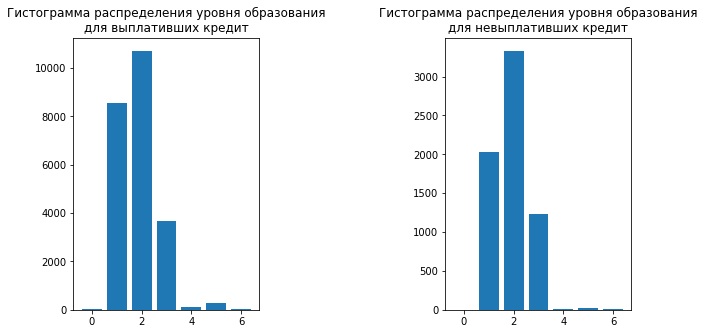

In [50]:
# Построим гистограммы распределений уровня образования для выплативших и невыплативших кредит
paid = df[df.default == 0].EDUCATION
paid_count = paid.value_counts(sort=False)
default = df[df.default == 1].EDUCATION
default_count = default.value_counts(sort=False)
default_count[0] = 0
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].bar(paid_count.index, paid_count)
axes[0].set_title("Гистограмма распределения уровня образования\nдля выплативших кредит")
axes[1].bar(default_count.index, default_count)
axes[1].set_title("Гистограмма распределения уровня образования\nдля невыплативших кредит")
plt.subplots_adjust(wspace=1)



По графикам видно, что среди выплативших выше доля докторов и магистров, и ниже доля бакалавров и выпускников школы.

In [51]:
# Построим таблицу сопряженности уровня образования и выплаты кредита
contingency_table = pd.DataFrame(np.vstack((paid_count.sort_index(), default_count.sort_index())).T)
contingency_table.columns = ['paid', 'default_observed']
contingency_table['default_expected'] = contingency_table['paid'] / contingency_table['paid'].sum() * contingency_table['default_observed'].sum()
contingency_table['difference'] = contingency_table.default_observed - contingency_table.default_expected
contingency_table

,paid,default_observed,default_expected,difference
0,14,0,3.976374,-3.976374
1,8549,2036,2428.144325,-392.144325
2,10700,3330,3039.085773,290.914227
3,3680,1237,1045.218285,191.781715
4,116,7,32.947098,-25.947098
5,262,18,74.414997,-56.414997
6,43,8,12.213148,-4.213148


In [52]:
# Проверим гипотезу об отсутствии влияния образования на возврат кредита с помощью критерия Хи-квадрат
# H0: F1(x) = F2(x) (Распределения уровня образования не отличаются для вернувших и невернувших кредит) 
# Н1: F1(x) != F2(x) (Распределения уровня образования отличаются для вернувших и невернувших кредит)

_, p = sts.chisquare(contingency_table.default_observed, contingency_table.default_expected)
hypothesis_check(p)

Достигаемый уровень значимости: 2.197883571213863e-39
Гипотеза Н0 отвергается на уровне значимости 0.05


Гипотеза об отсутствии влияния образования на возврат кредита уверенно отклоняется. Из таблицы сопряженности следует, что наличие магистерского образования и докторской степени является индикатором возврата кредита, а наличие степени бакалавра или школьного - индикатором невозврата.

## Задание 4

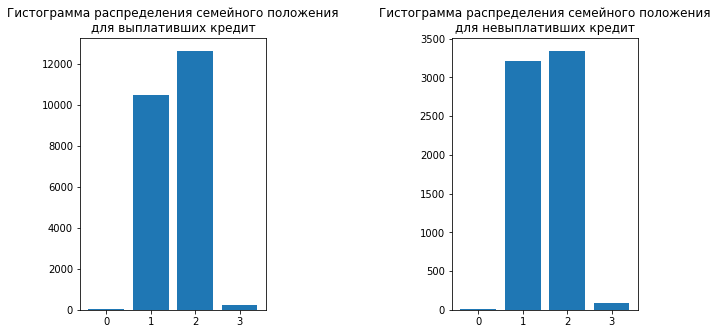

In [53]:
# Построим гистограммы распределения семейного положения среди тех, кто вернул и не вернул кредит
paid = df[df.default == 0].MARRIAGE
default = df[df.default == 1].MARRIAGE
paid_count = paid.value_counts(sort=False)
default_count = default.value_counts(sort=False)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].bar(paid_count.index, paid_count)
axes[0].set_title("Гистограмма распределения семейного положения\nдля выплативших кредит")
axes[1].bar(default_count.index, default_count)
axes[1].set_title("Гистограмма распределения семейного положения\nдля невыплативших кредит")
plt.subplots_adjust(wspace=1)


По гистограммам видно, что среди выплативших кредит доля холостых слегка выше доли замужних/женатых, тогда как среди невыплативших доли холостых и замужних/женатых примерно равны.

In [54]:
# Мы имеем 2 категориальных признака, у семейного положения 4 градации, у возврата кредита - 2. 
# Чтобы измерить степень ассоциации между ними посчитаем коэффициент V Крамера.

def cramer(matrix):
    chi2 = sts.chi2_contingency(matrix)[0]
    n = sum(matrix.sum())
    phi2 = chi2 / n
    r, k = matrix.shape
    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

matrix = pd.crosstab(df.default, df.MARRIAGE)
print("Коэффициент V Крамера между семейным положением и возвратом кредита:", cramer(matrix))

Коэффициент V Крамера между семейным положением и возвратом кредита: 0.014009346970837748


Коэффициент V Крамера близок к нулю, из чего можно сделать вывод об отсутствии ассоциации между семейным положением и возвратом кредита.

## Задание 5

Text(0.5, 1.0, 'Гистограмма распределения возраста\nдля невыплативших кредит')

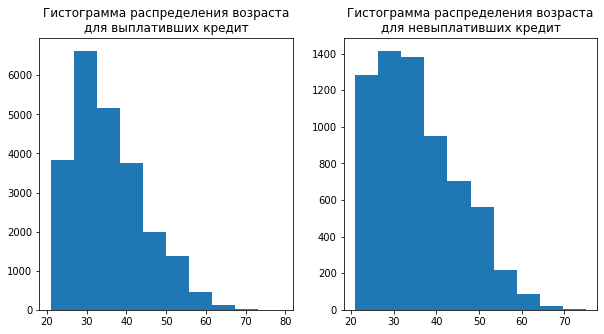

In [55]:
#Построим гистограммы распределения возраста
paid = df[df.default == 0].AGE.values
default = df[df.default == 1].AGE.values
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].hist(paid)
axes[0].set_title("Гистограмма распределения возраста\nдля выплативших кредит")
axes[1].hist(default)
axes[1].set_title("Гистограмма распределения возраста\nдля невыплативших кредит")

На гистограммах не видно значительных различий в распределениях возраста выплативших и невыплативших кредит.

In [56]:
# Рассчитаем доверительный интервал для разности медиан возрастов выплативших и невыплативших кредит с помощью бутстрепа и проверим гипотезу о их равенстве: 
# H0: M1=M2 (медианы возрастов равны)
# H1: M1!= M2 (медианы возрастов не равны)

paid_median_scores = list(map(np.median, get_bootstrap_samples(paid, 1000)))
default_median_scores = list(map(np.median, get_bootstrap_samples(default, 1000)))

print("Точечная оценка медины кредитного лимита для выплативших кредит: ", np.median(paid))
print("Точечная оценка медины кредитного лимита для невыплативших кредит: ", np.median(default))

delta_median_scores = list(map(lambda x: x[0] - x[1], zip(paid_median_scores, default_median_scores)))
print("95% доверительный интервал для разности медиан",  stat_intervals(delta_median_scores, 0.05))

Точечная оценка медины кредитного лимита для выплативших кредит:  34.0
Точечная оценка медины кредитного лимита для невыплативших кредит:  34.0
95% доверительный интервал для разности медиан [-1.  0.]


Доверительный интервал содержит 0, следовательно гипотеза о равестве медиан принимается.

In [57]:
# Проверим гипотезу о равенстве распределений возрастов вернувших и не вернувших кредит с помощью критерия Манна-Уитни (так как выборки независимы)
# H0: F_x1(x) = F_x2(x) (выборки получены из одного распределения)
# H1: F_x1(x) = F_x2(x + delta), delta != 0 (выборки получены из разных распределений)

def hypothesis_check(p, alpha=0.05):
    print("Достигаемый уровень значимости:", p)
    if p < alpha:
        print("Гипотеза Н0 отвергается на уровне значимости", alpha)
    else:
        print("Гипотеза Н0 принимается на уровне значимости", alpha)

_, p = sts.mannwhitneyu(paid, default, alternative="two-sided")
hypothesis_check(p)

Достигаемый уровень значимости: 0.3725035434898616
Гипотеза Н0 принимается на уровне значимости 0.05


Гипотеза о равенстве распределений возрастов принимается, и исходя также из проведенной выше проверки гипотезы о равенстве медиан, можно сделать вывод что возраст не влияет на возврат кредита.